# Kmeans

* Use Python as a programming language and analyze

# KMeans
Data file:
* sklearn:20newsgroups

### Import libraries

In [324]:
%%time

import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score

CPU times: user 149 µs, sys: 11 µs, total: 160 µs
Wall time: 165 µs


In [325]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### 1. Please load newgroups dataset and examine the data by showing the first five rows

In [326]:
news_groups = fetch_20newsgroups(subset='all')

for i in news_groups:
  print(i)

data
filenames
target_names
target
DESCR


In [327]:
df = pd.DataFrame({
    'article': news_groups.data,
    'filenames': news_groups.filenames,
    'target': news_groups.target,
    'target_names': [news_groups.target_names[i] for i in news_groups.target]
    })

df.shape

(18846, 4)

In [328]:
print(news_groups.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [329]:
len(news_groups.target_names)

20

In [330]:
df.head()

,article,filenames,target,target_names
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,/root/scikit_learn_data/20news_home/20news-byd...,10,rec.sport.hockey
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,/root/scikit_learn_data/20news_home/20news-byd...,3,comp.sys.ibm.pc.hardware
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,/root/scikit_learn_data/20news_home/20news-byd...,17,talk.politics.mideast
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,/root/scikit_learn_data/20news_home/20news-byd...,3,comp.sys.ibm.pc.hardware
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,/root/scikit_learn_data/20news_home/20news-byd...,4,comp.sys.mac.hardware


In [331]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18846 entries, 0 to 18845
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article       18846 non-null  object
 1   filenames     18846 non-null  object
 2   target        18846 non-null  int64 
 3   target_names  18846 non-null  object
dtypes: int64(1), object(3)
memory usage: 589.1+ KB


In [332]:
df.isnull().sum()

,0
article,0
filenames,0
target,0
target_names,0


In [333]:
print(news_groups.DESCR[0:1000])

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

=================   ==========
Classes                     20
Samples total            18846
Dimensionality               1

### 2. Please output the number of articles in each newsgroup and selce the top 5 newsgroups

In [334]:
# number of articles in each newsgroup

df[['target', 'target_names']].value_counts(sort=True, ascending=False)

,,count
target,target_names,
10,rec.sport.hockey,999
15,soc.religion.christian,997
8,rec.motorcycles,996
9,rec.sport.baseball,994
11,sci.crypt,991
7,rec.autos,990
13,sci.med,990
5,comp.windows.x,988
14,sci.space,987


In [335]:
# selce the top 5 newsgroups

target = df[['target', 'target_names']].value_counts(sort=True, ascending=False).head()
target

,,count
target,target_names,
10,rec.sport.hockey,999
15,soc.religion.christian,997
8,rec.motorcycles,996
9,rec.sport.baseball,994
11,sci.crypt,991


### 3. From the step 2, you will findout the top 5 newsgroups are 10, 15,8,9,11. Please restrict data to articles from top 5 newsgroups


In [336]:
group_top5 = target.head().reset_index()['target'].to_list()
group_top5

[10, 15, 8, 9, 11]

In [337]:
# restrict data to articles from top 5 newsgroups

df_top5 = df[df['target'].isin(group_top5)].reset_index(drop=True)
df_top5.head()

,article,filenames,target,target_names
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,/root/scikit_learn_data/20news_home/20news-byd...,10,rec.sport.hockey
1,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,/root/scikit_learn_data/20news_home/20news-byd...,10,rec.sport.hockey
2,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,/root/scikit_learn_data/20news_home/20news-byd...,10,rec.sport.hockey
3,From: steve-b@access.digex.com (Steve Brinich)...,/root/scikit_learn_data/20news_home/20news-byd...,11,sci.crypt
4,From: pmetzger@snark.shearson.com (Perry E. Me...,/root/scikit_learn_data/20news_home/20news-byd...,11,sci.crypt


In [338]:
df_top5['target'].value_counts()

,count
target,
10,999
15,997
8,996
9,994
11,991


In [339]:
df_top5.shape

(4977, 4)

In [340]:
df2 = df_top5.copy()

### 4. Please remove the newline characters in the column "article" and create the cleaned article column by a function to lowercase, remove puncuation, tokenzie, remove stopwords, and lemmatize the articles.

I have attached some sample code for preprocessing text (by getting rid of punctuations and stop words, tokenzie, lemmatize and vectrize the text) and generating the word cloud in Assignment 5. The basic idea is to convert the text into the numbers and then put it into k-means clustering. You need to do some research on your own but you will find many sample code line for A5.  Hope it helps.

```
lem = WordNetLemmatizer()
def clean_text(text):
    stop = stopwords.words('english')
    text = "".join([word.lower() for word in text])
    tokens = re.split('\W+', text)
    text = [lem.lemmatize(word) for word in tokens if (word not in stop) and word.isalpha()]
    text_2 = ' '.join(word for word in text)
    return text_2  
df['article'] = df['article'].apply(clean_text)
# verctorize data

vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['article_clean'])
tfidf_matrix.shape
# generate the word cloud image
def makeImage(frequencies):
    # generate word cloud
    wc = WordCloud(background_color="white", max_words=50)
    wc.generate_from_frequencies(frequencies)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
for i in range(true_k):
    freq = frequencies_dict(i)
    makeImage(freq)
    print()
```

In [341]:
# remove \n
# lowercase

df2['article'] = df2['article'].str.replace('\n','').str.lower()

In [342]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [343]:
df2['article'].head()

,article
0,from: mamatha devineni ratnam <mr47+@andrew.cm...
1,from: dchhabra@stpl.ists.ca (deepak chhabra)su...
2,from: dchhabra@stpl.ists.ca (deepak chhabra)su...
3,from: steve-b@access.digex.com (steve brinich)...
4,from: pmetzger@snark.shearson.com (perry e. me...


In [344]:
# remove puncuation

translator = str.maketrans('', '', string.punctuation)
df2['article'] = df2['article'].str.translate(translator)
df2['article'].head()

,article
0,from mamatha devineni ratnam mr47andrewcmuedus...
1,from dchhabrastplistsca deepak chhabrasubject ...
2,from dchhabrastplistsca deepak chhabrasubject ...
3,from stevebaccessdigexcom steve brinichsubject...
4,from pmetzgersnarkshearsoncom perry e metzgers...


In [345]:
%%time
# tokenize

df2['article_tokenized'] = df2['article'].apply(word_tokenize)
df2.head()

CPU times: user 5.39 s, sys: 44.7 ms, total: 5.44 s
Wall time: 5.54 s


,article,filenames,target,target_names,article_tokenized
0,from mamatha devineni ratnam mr47andrewcmuedus...,/root/scikit_learn_data/20news_home/20news-byd...,10,rec.sport.hockey,"[from, mamatha, devineni, ratnam, mr47andrewcm..."
1,from dchhabrastplistsca deepak chhabrasubject ...,/root/scikit_learn_data/20news_home/20news-byd...,10,rec.sport.hockey,"[from, dchhabrastplistsca, deepak, chhabrasubj..."
2,from dchhabrastplistsca deepak chhabrasubject ...,/root/scikit_learn_data/20news_home/20news-byd...,10,rec.sport.hockey,"[from, dchhabrastplistsca, deepak, chhabrasubj..."
3,from stevebaccessdigexcom steve brinichsubject...,/root/scikit_learn_data/20news_home/20news-byd...,11,sci.crypt,"[from, stevebaccessdigexcom, steve, brinichsub..."
4,from pmetzgersnarkshearsoncom perry e metzgers...,/root/scikit_learn_data/20news_home/20news-byd...,11,sci.crypt,"[from, pmetzgersnarkshearsoncom, perry, e, met..."


In [346]:
# remove stopwords

stopwords.words('english')[:5]

['a', 'about', 'above', 'after', 'again']

In [347]:
stopwords_list = stopwords.words('english')

In [348]:
%%time

df2['article_tokenized'] = df2['article_tokenized'].apply(lambda x: [word for word in x if word not in stopwords_list and word.isalnum()])
df2.head()

CPU times: user 4.64 s, sys: 8 ms, total: 4.64 s
Wall time: 5.2 s


,article,filenames,target,target_names,article_tokenized
0,from mamatha devineni ratnam mr47andrewcmuedus...,/root/scikit_learn_data/20news_home/20news-byd...,10,rec.sport.hockey,"[mamatha, devineni, ratnam, mr47andrewcmuedusu..."
1,from dchhabrastplistsca deepak chhabrasubject ...,/root/scikit_learn_data/20news_home/20news-byd...,10,rec.sport.hockey,"[dchhabrastplistsca, deepak, chhabrasubject, a..."
2,from dchhabrastplistsca deepak chhabrasubject ...,/root/scikit_learn_data/20news_home/20news-byd...,10,rec.sport.hockey,"[dchhabrastplistsca, deepak, chhabrasubject, g..."
3,from stevebaccessdigexcom steve brinichsubject...,/root/scikit_learn_data/20news_home/20news-byd...,11,sci.crypt,"[stevebaccessdigexcom, steve, brinichsubject, ..."
4,from pmetzgersnarkshearsoncom perry e metzgers...,/root/scikit_learn_data/20news_home/20news-byd...,11,sci.crypt,"[pmetzgersnarkshearsoncom, perry, e, metzgersu..."


In [349]:
# lemmatize

wl = WordNetLemmatizer()

df2['article_tokenized'] = df2['article_tokenized'].apply(lambda x: [wl.lemmatize(word) for word in x])
df2.head()

,article,filenames,target,target_names,article_tokenized
0,from mamatha devineni ratnam mr47andrewcmuedus...,/root/scikit_learn_data/20news_home/20news-byd...,10,rec.sport.hockey,"[mamatha, devineni, ratnam, mr47andrewcmuedusu..."
1,from dchhabrastplistsca deepak chhabrasubject ...,/root/scikit_learn_data/20news_home/20news-byd...,10,rec.sport.hockey,"[dchhabrastplistsca, deepak, chhabrasubject, a..."
2,from dchhabrastplistsca deepak chhabrasubject ...,/root/scikit_learn_data/20news_home/20news-byd...,10,rec.sport.hockey,"[dchhabrastplistsca, deepak, chhabrasubject, g..."
3,from stevebaccessdigexcom steve brinichsubject...,/root/scikit_learn_data/20news_home/20news-byd...,11,sci.crypt,"[stevebaccessdigexcom, steve, brinichsubject, ..."
4,from pmetzgersnarkshearsoncom perry e metzgers...,/root/scikit_learn_data/20news_home/20news-byd...,11,sci.crypt,"[pmetzgersnarkshearsoncom, perry, e, metzgersu..."


In [350]:
# convert [] to str

df2['article_tokenized'] = df2['article_tokenized'].apply(lambda x: ' '.join(word for word in x))
df2.head()

,article,filenames,target,target_names,article_tokenized
0,from mamatha devineni ratnam mr47andrewcmuedus...,/root/scikit_learn_data/20news_home/20news-byd...,10,rec.sport.hockey,mamatha devineni ratnam mr47andrewcmuedusubjec...
1,from dchhabrastplistsca deepak chhabrasubject ...,/root/scikit_learn_data/20news_home/20news-byd...,10,rec.sport.hockey,dchhabrastplistsca deepak chhabrasubject atlan...
2,from dchhabrastplistsca deepak chhabrasubject ...,/root/scikit_learn_data/20news_home/20news-byd...,10,rec.sport.hockey,dchhabrastplistsca deepak chhabrasubject goali...
3,from stevebaccessdigexcom steve brinichsubject...,/root/scikit_learn_data/20news_home/20news-byd...,11,sci.crypt,stevebaccessdigexcom steve brinichsubject figh...
4,from pmetzgersnarkshearsoncom perry e metzgers...,/root/scikit_learn_data/20news_home/20news-byd...,11,sci.crypt,pmetzgersnarkshearsoncom perry e metzgersubjec...


### 5. Please use TfidfVectorizer to vectorize data and establish tfidf matrix

In [351]:
%%time

vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words='english')

tfidf_matrix = vectorizer.fit_transform(df2['article_tokenized'])
tfidf_matrix

CPU times: user 7.16 s, sys: 223 ms, total: 7.38 s
Wall time: 7.44 s


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1836161 stored elements and shape (4977, 1075119)>

In [352]:
list(vectorizer.vocabulary_.items())[:3]

[('mamatha', 604184), ('devineni', 314422), ('ratnam', 780588)]

In [353]:
tfidf_matrix[0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 212 stored elements and shape (1, 1075119)>

In [354]:
first_document_tfidf = tfidf_matrix[0]

tfidf_df = pd.DataFrame(first_document_tfidf.T.todense(), index=vectorizer.get_feature_names_out(), columns=['TF-IDF'])

tfidf_df.sort_values(by=['TF-IDF'], ascending=False)

,TF-IDF
pen,0.235529
game pen,0.130847
pen fan,0.116353
jagr,0.100640
bit,0.091193
...,...
episodesof mr rogers,0.000000
episodesof mr,0.000000
episodesof,0.000000
episodeill 55 10,0.000000


### 6. Train KMeans model and intantiate Kmeans Classifier by k=5 and use km.fit(tfidf_matrix).

In [355]:
%%time

# Train KMeans model and intantiate Kmeans Classifier by k=5

km = KMeans(n_clusters=5, random_state=42, n_init='auto')
km.fit(tfidf_matrix)

# cluster labels

km.labels_

CPU times: user 2.41 s, sys: 577 ms, total: 2.99 s
Wall time: 2.98 s


array([3, 3, 3, ..., 1, 3, 2], dtype=int32)

In [356]:
km.labels_.shape

(4977,)

In [357]:
# cluster centers

km.cluster_centers_

array([[1.17919475e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.52880030e-05, 7.52880030e-05, 7.52880030e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.25252647e-04, 6.07248354e-05, 6.07248354e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.60155781e-05, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [358]:
km.cluster_centers_.shape

(5, 1075119)

### 7. Evaluate KMeans model by outputing the homogeneity, completeness, V-measure and Ajusted Rand-Index

In [359]:
true_labels = df2['target'].values
true_labels.shape

(4977,)

In [360]:
# outputing the homogeneity, completeness, V-measure and Ajusted Rand-Index

homogeneity = homogeneity_score(true_labels, km.labels_)
print(f'homogeneity_score: {homogeneity:.4f}')

completeness = completeness_score(true_labels, km.labels_)
print(f'completeness_score: {completeness:.4f}')

v_measure = v_measure_score(true_labels, km.labels_)
print(f'v_measure_score: {v_measure:.4f}')

ari = adjusted_rand_score(true_labels, km.labels_)
print(f'adjusted_rand_score: {ari:.4f}')

homogeneity_score: 0.5643
completeness_score: 0.6371
v_measure_score: 0.5985
adjusted_rand_score: 0.4470


### 8. Please identify the 10 most relevant terms in each cluster

In [361]:
km.n_clusters

5

In [362]:
vectorizer.get_feature_names_out()

array(['00', '00 00', '00 00 000', ..., 'ête', 'ête renvers',
       'ête renvers ée'], dtype=object)

In [363]:
vectorizer.get_feature_names_out().shape

(1075119,)

In [364]:
# identify the 10 most relevant terms in each cluster

cluster_labels = km.labels_
cluster_centers = km.cluster_centers_
n_top_words = 10

vocabulary = vectorizer.get_feature_names_out()

for i in range(km.n_clusters):

    print(f'cluster {i}:')

    # from km
    top_word_indices = cluster_centers[i].argsort()[::-1][:n_top_words]

    # from vectorizer
    top_words = [vocabulary[index] for index in top_word_indices]

    print(top_words, '\n')

cluster 0:
['bike', 'dod', 'article', 'motorcycle', 'ride', 'like', 'riding', 'dog', 'helmet', 'rider'] 

cluster 1:
['key', 'code', 'pgp', 'article', 'version', 'public', 'people', 'email', 'good', 'know'] 

cluster 2:
['god', 'christian', 'jesus', 'church', 'sin', 'people', 'bible', 'christ', 'believe', 'say'] 

cluster 3:
['game', 'team', 'player', 'year', 'university', 'article', 'hockey', 'fan', 'win', 'think'] 

cluster 4:
['key', 'chip', 'clipper', 'encryption', 'government', 'clipper chip', 'algorithm', 'phone', 'escrow', 'use'] 



### 9. Please generate word cloud image for each cluster



CPU times: user 11 s, sys: 245 ms, total: 11.2 s
Wall time: 11.7 s


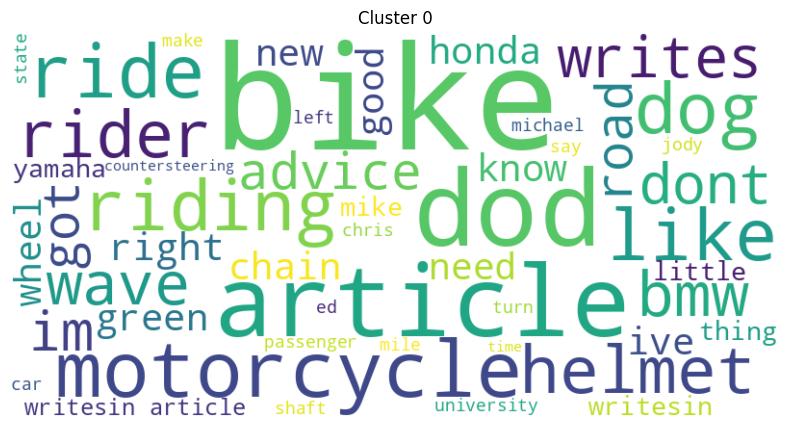

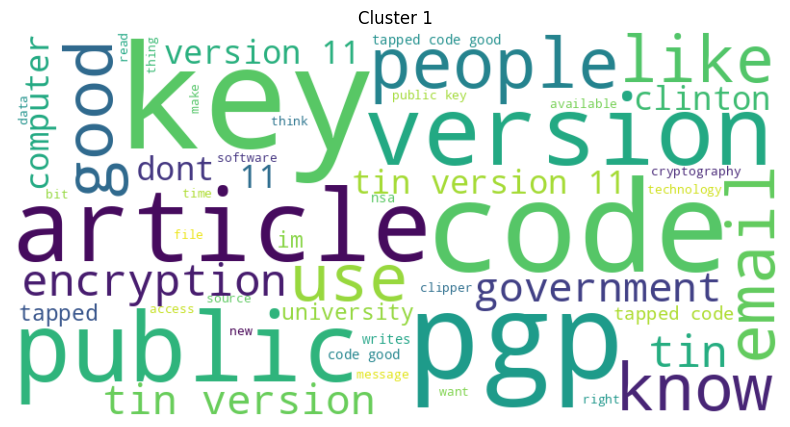

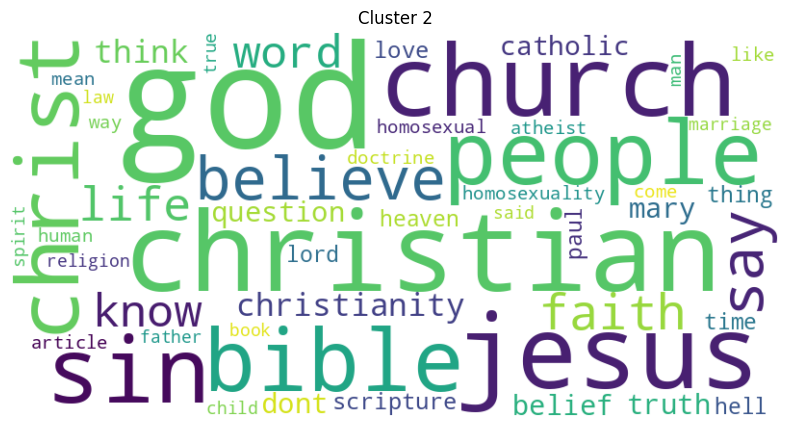

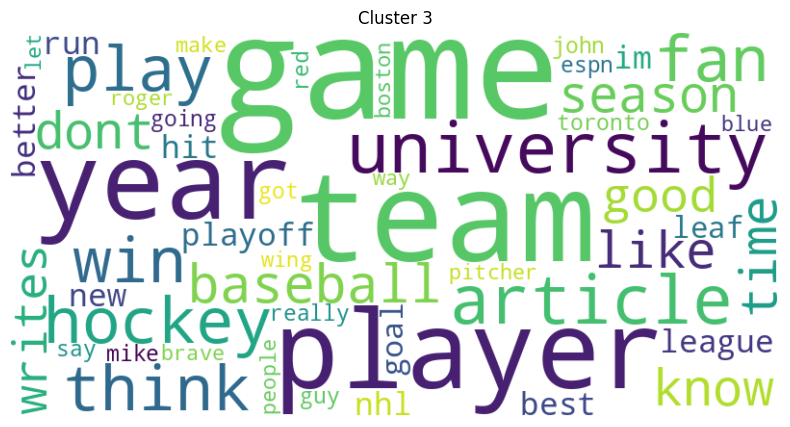

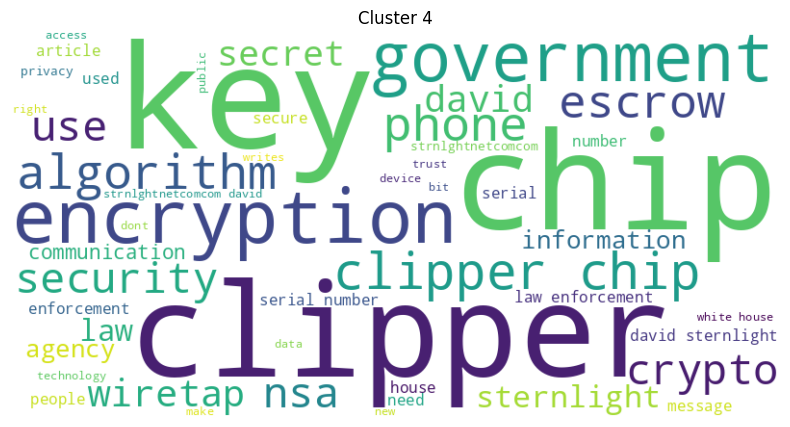

In [365]:
%%time

# generate word cloud image for each cluster

for i in range(km.n_clusters):

    top_word_indices = cluster_centers[i].argsort()[::-1]

    # actual words and TF-IDF weights
    top_words = {vocabulary[index]: cluster_centers[i, index] for index in top_word_indices}

    # WordCloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        prefer_horizontal=0.9,
        min_font_size=10,
        max_font_size=150,
        random_state=42,
        max_words=50
    )

    wordcloud.generate_from_frequencies(top_words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {i}')

### 10. Could you please check each cloud map and name each cluster based on your own expertise?

In [368]:
# cluster 0: bike dod article motorcycle helmet
# cluster 1: key article code public pgp
# cluster 2: god church christian bible jesus
# cluster 3: game year university team player
# cluster 4: key encryption chip clipper government

# here's my name for each cluster:
c0_name = 'Motorcycle Transportation Safety Discussion'
c1_name = 'Cryptography and Public Key Infrastructure Discussion'
c2_name = 'Christian Theology and Religion Discussion'
c3_name = 'Academic Sports and Collegiate Athletics Discussion'
c4_name = 'Government Surveillance and Encryption Policy Discussion'

In [369]:
!jupyter nbconvert --to html '/content/drive/MyDrive/dat/HW5_9660_Student_250507.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/dat/HW5_9660_Student_250507.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 1613162 bytes to /content/drive/MyDrive/dat/HW5_9660_Student_250507.html
